In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm.auto import tqdm

from loren_frank_data_processing import (make_epochs_dataframe, make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from ZilongCode.utils import get_sweep_and_shuffled_awake_replay_results_using_postive_negative_peak_in_LFP

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]


n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

180.4300774105589

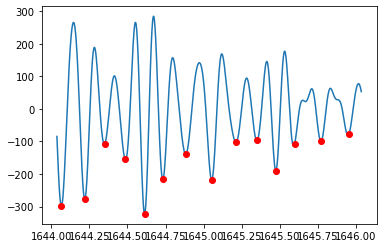

In [4]:
#test the load of LFP info
import os
import pandas as pd
import pickle
import xarray as xr
from ZilongCode.utils import bandpassfilter,get_zero_phase
epoch_key = ('bon', 8, 2)
animal, day, epoch = epoch_key
datadir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"
cv_classifier_clusterless_results = xr.open_dataset(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
with open(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
    speed_dic = pickle.load(f)
with open(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl'), 'rb') as f:
    lfp = pickle.load(f)

lfp = (
    lfp.reset_index(drop=True).set_index(lfp.index / np.timedelta64(1, "s"))
)

# add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
# group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)

zero_phase_index = get_zero_phase(lfp0.iloc[0:1000])

plt.plot(lfp0.iloc[0:1000])
#add zero phase to lfp0 as red point
plt.plot(lfp0.index[zero_phase_index], lfp0.iloc[zero_phase_index], 'ro')

# cv_classifier_clusterless_results.mental_distance_from_actual_position.shape

data_ = cv_classifier_clusterless_results.mental_distance_from_actual_position_ahead_behind.data
np.max(data_)

### 1, get correlation between theta sweep length and the awake replay diffusion exponent

In [5]:
#animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']
animal_names = ['bon', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']
all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_sweep_amp_peranimal = {}; all_sweep_amp_perday = {}
all_sweep_ahead_peranimal = {}; all_sweep_ahead_perday = {}
all_sweep_behind_peranimal = {}; all_sweep_behind_perday = {}
all_sweep_mass_peranimal = {}; all_sweep_mass_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
all_ave_activespeed_peranimal = {}; all_ave_activespeed_perday = {}
all_behav_exponent_peranimal = {}; all_behav_exponent_perday = {}
Sweep_DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'
Replay_DATA_DIR = '/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories_shuffled/'
for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )
    
    sweep_len = []
    sweep_amp = []
    sweep_ahead = []
    sweep_behind = []
    sweep_mass = []
    exponent = []
    intercept = []
    ave_speed = []
    ave_activespeed = []
    behav_exponent = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ('egy', 10, 2):
            continue
        
        if (animal, day, epoch) == ('bon', 4, 2):
            continue

        print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
        
        #get the average sweep length and replay exponent
        results  = get_sweep_and_shuffled_awake_replay_results_using_postive_negative_peak_in_LFP(epoch_key, Sweep_DATA_DIR, Replay_DATA_DIR, sweep_speed_threshold=4)
        
        [mean_immobile_speed, 
         mean_active_speed, 
         behav_exp, 
         mean_sweep_dist, 
         mean_sweep_amp, 
         mean_sweep_ahead, 
         mean_sweep_behind, 
         sweep_mass_i,
         replay_exponent, 
         replay_intercept] = results
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        # print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        print(f'Sweep length: {mean_sweep_dist:.3f}, \
              Sweep amp: {mean_sweep_amp:.3f}, \
              Sweep ahead: {mean_sweep_ahead},\
              Sweep behind: {mean_sweep_behind},\
              Sweep mass: {sweep_mass_i:.3f},\
              Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_sweep_amp_perday.setdefault((animal, day), []).append(mean_sweep_amp)
        all_sweep_ahead_perday.setdefault((animal, day), []).append(mean_sweep_ahead)
        all_sweep_behind_perday.setdefault((animal, day), []).append(mean_sweep_behind)
        all_sweep_mass_perday.setdefault((animal, day), []).append(sweep_mass_i)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal, day), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        all_ave_activespeed_perday.setdefault((animal, day), []).append(mean_active_speed)
        all_behav_exponent_perday.setdefault((animal, day), []).append(behav_exp)
        
        ave_speed.append(mean_immobile_speed)
        ave_activespeed.append(mean_active_speed)
        behav_exponent.append(behav_exp)
        sweep_len.append(mean_sweep_dist)
        sweep_amp.append(mean_sweep_amp)
        sweep_ahead.append(mean_sweep_ahead)
        sweep_behind.append(mean_sweep_behind)
        sweep_mass.append(sweep_mass_i)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_ave_activespeed_peranimal[name] = ave_activespeed
    all_behav_exponent_peranimal[name] = behav_exponent
    all_sweep_len_peranimal[name] = sweep_len
    all_sweep_amp_peranimal[name] = sweep_amp
    all_sweep_ahead_peranimal[name] = sweep_ahead
    all_sweep_behind_peranimal[name] = sweep_behind
    all_sweep_mass_peranimal[name] = sweep_mass
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2


Sweep length: 28.694,               Sweep amp: 49.932,               Sweep ahead: 10.772131907419803,              Sweep behind: -39.16012928329926,              Sweep mass: -13.151,              Diffusion exponent: 0.693
Animal: bon, Day: 3, Epoch: 4
Sweep length: 15.452,               Sweep amp: 34.348,               Sweep ahead: 16.73425544943845,              Sweep behind: -17.613581409647303,              Sweep mass: -0.159,              Diffusion exponent: 0.552
Animal: bon, Day: 3, Epoch: 6
Sweep length: 22.764,               Sweep amp: 43.452,               Sweep ahead: 19.865927049294058,              Sweep behind: -23.58567161166832,              Sweep mass: -1.558,              Diffusion exponent: 0.608
Animal: bon, Day: 4, Epoch: 4
Sweep length: 17.515,               Sweep amp: 35.363,               Sweep ahead: 15.580431096896582,              Sweep behind: -19.78222645907459,              Sweep mass: -2.117,              Diffusion exponent: 0.567
Animal: bon, Day: 4, Epoc

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2
Sweep length: 51.268,               Sweep amp: 59.189,               Sweep ahead: 2.1219771584998868,              Sweep behind: -57.06675989511817,              Sweep mass: -27.359,              Diffusion exponent: 0.603
Animal: dud, Day: 5, Epoch: 2
Sweep length: 41.509,               Sweep amp: 61.440,               Sweep ahead: 9.962644897561413,              Sweep behind: -51.47720957670297,              Sweep mass: -20.460,              Diffusion exponent: 0.895


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 2
Sweep length: 29.336,               Sweep amp: 47.896,               Sweep ahead: 16.84197265822185,              Sweep behind: -31.053568525823493,              Sweep mass: -5.093,              Diffusion exponent: 0.838
Animal: con, Day: 1, Epoch: 4
Sweep length: 21.269,               Sweep amp: 46.733,               Sweep ahead: 16.529238228070973,              Sweep behind: -30.20408623056983,              Sweep mass: -4.873,              Diffusion exponent: 0.613
Animal: con, Day: 2, Epoch: 2
Sweep length: 25.001,               Sweep amp: 46.062,               Sweep ahead: 11.415686630093116,              Sweep behind: -34.646130831318175,              Sweep mass: -10.422,              Diffusion exponent: 1.094
Animal: con, Day: 2, Epoch: 4
Sweep length: 22.739,               Sweep amp: 47.894,               Sweep ahead: 18.553943098754658,              Sweep behind: -29.34049203246532,              Sweep mass: -3.945,              Diffusion exponent: 

epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 2
Sweep length: 37.958,               Sweep amp: 57.207,               Sweep ahead: 22.202876017256337,              Sweep behind: -35.004046333742075,              Sweep mass: -5.957,              Diffusion exponent: 0.867
Animal: dav, Day: 3, Epoch: 4
Sweep length: 31.233,               Sweep amp: 51.060,               Sweep ahead: 20.64958303380829,              Sweep behind: -30.41031135605603,              Sweep mass: -4.799,              Diffusion exponent: 0.911
Animal: dav, Day: 3, Epoch: 6
Sweep length: 33.076,               Sweep amp: 53.330,               Sweep ahead: 18.177079380837405,              Sweep behind: -35.15268417518741,              Sweep mass: -7.708,              Diffusion exponent: 0.877
Animal: dav, Day: 4, Epoch: 2
Sweep length: 45.286,               Sweep amp: 57.930,               Sweep ahead: 17.766910372211214,              Sweep behind: -40.16341800224486,              Sweep mass: -11.100,              Diffusion exponent: 0

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Animal: Cor, Day: 1, Epoch: 2
Sweep length: 47.554,               Sweep amp: 64.032,               Sweep ahead: 23.15718314407996,              Sweep behind: -40.8752140104806,              Sweep mass: -8.641,              Diffusion exponent: 0.731
Animal: Cor, Day: 1, Epoch: 4
Sweep length: 26.151,               Sweep amp: 51.277,               Sweep ahead: 20.608415983185786,              Sweep behind: -30.66839869869955,              Sweep mass: -4.451,              Diffusion exponent: 0.739
Animal: Cor, Day: 2, Epoch: 2
Sweep length: 27.537,               Sweep amp: 56.062,               Sweep ahead: 22.406524561491242,              Sweep behind: -33.65528427276876,              Sweep mass: -5.436,              Diffusion exponent: 0.683
Animal: Cor, Day: 2, Epoch: 4
Sweep length: 25.822,               Sweep amp: 52.966,               Sweep ahead: 22.645655728782664,              Sweep behind: -30.320145652345992,              Sweep mass: -2.464,              Diffusion exponent: 0.6

epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2
Sweep length: 30.278,               Sweep amp: 55.842,               Sweep ahead: 19.902589368978894,              Sweep behind: -35.93989326500322,              Sweep mass: -7.419,              Diffusion exponent: 0.896
Animal: egy, Day: 5, Epoch: 4
Sweep length: 26.949,               Sweep amp: 53.198,               Sweep ahead: 21.3110728951095,              Sweep behind: -31.887062489527814,              Sweep mass: -4.548,              Diffusion exponent: 0.942
Animal: egy, Day: 5, Epoch: 6
Sweep length: 29.352,               Sweep amp: 51.894,               Sweep ahead: 18.29353222314101,              Sweep behind: -33.60002122444148,              Sweep mass: -7.332,              Diffusion exponent: 0.866
Animal: egy, Day: 6, Epoch: 4
Sweep length: 38.525,               Sweep amp: 60.719,               Sweep ahead: 24.104238908438425,              Sweep behind: -36.614440083793404,              Sweep mass: -5.221,              Diffusion exponent: 0.9

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2
Sweep length: 50.093,               Sweep amp: 56.508,               Sweep ahead: 10.312617961571947,              Sweep behind: -46.19547833592155,              Sweep mass: -16.509,              Diffusion exponent: 0.851
Animal: cha, Day: 4, Epoch: 4
Sweep length: 46.601,               Sweep amp: 61.412,               Sweep ahead: 11.247127064456166,              Sweep behind: -50.16468630943918,              Sweep mass: -18.751,              Diffusion exponent: 0.874
Animal: cha, Day: 8, Epoch: 2
Sweep length: 50.168,               Sweep amp: 57.295,               Sweep ahead: 10.513300573084463,              Sweep behind: -46.78216298502206,              Sweep mass: -18.063,              Diffusion exponent: 0.879
Animal: cha, Day: 8, Epoch: 4
Sweep length: 40.948,               Sweep amp: 61.646,               Sweep ahead: 15.82951020794724,              Sweep behind: -45.8161387439573,              Sweep mass: -13.778,              Diffusion exponent: 

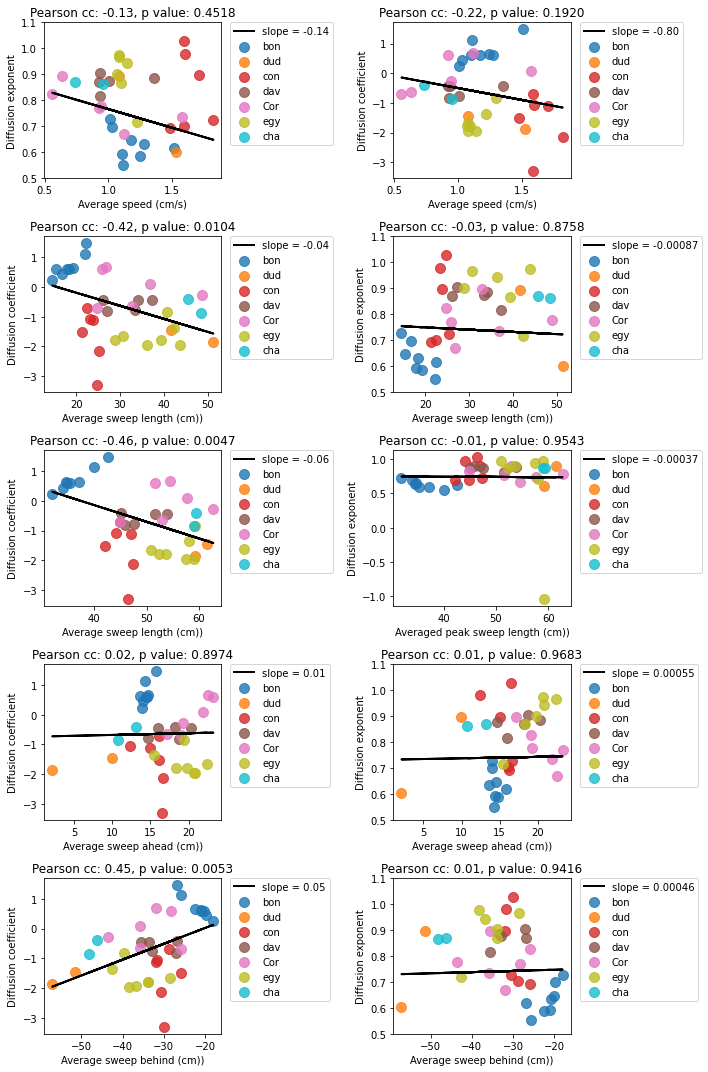

In [6]:
#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday...
all_ave_speed_perday_ave = {}
all_ave_activespeed_perday_ave = {}
all_behav_exponent_perday_ave = {}
all_sweep_len_perday_ave = {}
all_sweep_amp_perday_ave = {}
all_sweep_ahead_perday_ave = {}
all_sweep_behind_perday_ave = {}
all_sweep_mass_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_ave_activespeed_perday_ave[key] = np.mean(all_ave_activespeed_perday[key])
    all_behav_exponent_perday_ave[key] = np.mean(all_behav_exponent_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_sweep_amp_perday_ave[key] = np.mean(all_sweep_amp_perday[key])
    all_sweep_ahead_perday_ave[key] = np.mean(all_sweep_ahead_perday[key])
    all_sweep_behind_perday_ave[key] = np.mean(all_sweep_behind_perday[key])
    all_sweep_mass_perday_ave[key] = np.mean(all_sweep_mass_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_ave_activespeed_perday_concat = {}
all_behav_exponent_perday_concat = {}
all_sweep_len_perday_concat = {}
all_sweep_amp_perday_concat = {}
all_sweep_ahead_perday_concat = {}
all_sweep_behind_perday_concat = {}
all_sweep_mass_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_ave_activespeed_perday_concat.setdefault(key[0], []).append(all_ave_activespeed_perday_ave[key])
    all_behav_exponent_perday_concat.setdefault(key[0], []).append(all_behav_exponent_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_sweep_amp_perday_concat.setdefault(key[0], []).append(all_sweep_amp_perday_ave[key])
    all_sweep_ahead_perday_concat.setdefault(key[0], []).append(all_sweep_ahead_perday_ave[key])
    all_sweep_behind_perday_concat.setdefault(key[0], []).append(all_sweep_behind_perday_ave[key])
    all_sweep_mass_perday_concat.setdefault(key[0], []).append(all_sweep_mass_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
#delete fra from animal_names

colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(10,15))

plt.subplot(5,2,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)

#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed (cm/s)')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

#intercept
plt.subplot(5,2,2)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, intercept_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)

#pearson test
corr, p = pearsonr(speed_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed (cm/s)')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,3)
#plot all_intercept_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, intercept_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,4)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(5,2,5)
#plot all_intercept_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_amp_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, intercept_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,6)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_amp_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Averaged peak sweep length (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,7)
#plot all_intercept_perday_concat against all_sweep_ahead_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_ahead_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_ahead_perday_concat and all_intercept_perday_concat to numpy array   
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_ahead_np = np.concatenate(list(all_sweep_ahead_perday_concat.values()))
slope, intercept = np.polyfit(sweep_ahead_np, intercept_np, 1)
plt.plot(sweep_ahead_np, sweep_ahead_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_ahead_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep ahead (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,8)
#plot all_exponent_perday_concat against all_sweep_ahead_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_ahead_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_ahead_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_ahead_np = np.concatenate(list(all_sweep_ahead_perday_concat.values()))
slope, intercept = np.polyfit(sweep_ahead_np, exp_np, 1)
plt.plot(sweep_ahead_np, sweep_ahead_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_ahead_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep ahead (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(5,2,9)
#plot all_intercept_perday_concat against all_sweep_behind_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_behind_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_behind_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_behind_np = np.concatenate(list(all_sweep_behind_perday_concat.values()))
slope, intercept = np.polyfit(sweep_behind_np, intercept_np, 1)
plt.plot(sweep_behind_np, sweep_behind_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_behind_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep behind (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,10)
#plot all_exponent_perday_concat against all_sweep_behind_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_behind_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_behind_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_behind_np = np.concatenate(list(all_sweep_behind_perday_concat.values()))
slope, intercept = np.polyfit(sweep_behind_np, exp_np, 1)
plt.plot(sweep_behind_np, sweep_behind_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_behind_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep behind (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])


plt.tight_layout()
plt.show()

# store animal_names, all_sweep_len_perday_concat, all_exponent_perday_concat together in one pkl file 
# using pickle for producing paper figure in another script
import pickle
with open('../../Processed-Data/sweep_shuffled_replay_correlation_realdata.pkl', 'wb') as f:
    pickle.dump([animal_names, all_sweep_len_perday_concat, all_sweep_amp_perday_concat, all_sweep_ahead_perday_concat, all_sweep_behind_perday_concat, all_exponent_perday_concat, all_ave_activespeed_perday_concat], f)




### check the correlation with active speed

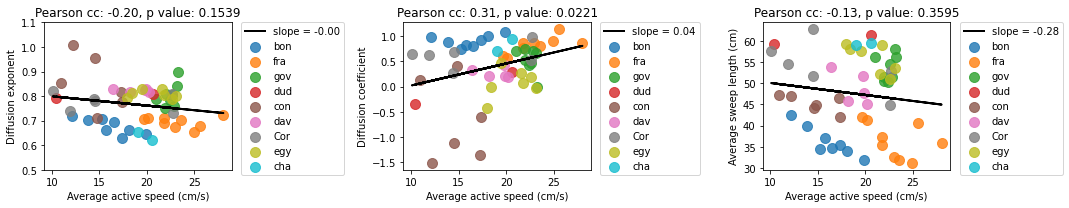

In [59]:
#plot the exponent against average active speed, and intercept against average active speed
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_activespeed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_activespeed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_activespeed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_activespeed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average active speed (cm/s)')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

#intercept
plt.subplot(1,3,2)
#plot all_intercept_perday_concat against all_ave_activespeed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_activespeed_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_activespeed_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_activespeed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, intercept_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(speed_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average active speed (cm/s)')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#plot sweep length against average active speed
plt.subplot(1,3,3)
#plot all_sweep_amp_perday_concat against all_ave_activespeed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_activespeed_perday_concat[name]), 
                np.array(all_sweep_amp_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_activespeed_perday_concat and all_sweep_amp_perday_concat to numpy array
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_activespeed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, sweep_len_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(speed_np, sweep_len_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average active speed (cm/s)')
plt.ylabel('Average sweep length (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    

plt.tight_layout()
plt.show()


### check the delay compensation

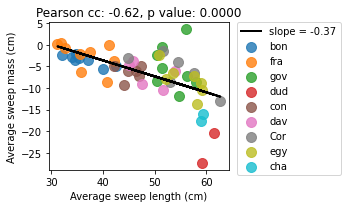

In [12]:
#check the correlation between all_sweep_mass_perday_concat and all_swep_len_perday_concat
plt.figure(figsize=(5,3))
#plot all_sweep_mass_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_amp_perday_concat[name]), 
                np.array(all_sweep_mass_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_sweep_mass_perday_concat to numpy array
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
sweep_mass_np = np.concatenate(list(all_sweep_mass_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, sweep_mass_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)

#pearson test
corr, p = pearsonr(sweep_len_np, sweep_mass_np)

plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm)')
plt.ylabel('Average sweep mass (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

### check the experience effect on theat sweep length and replay diffusivity. across epochs

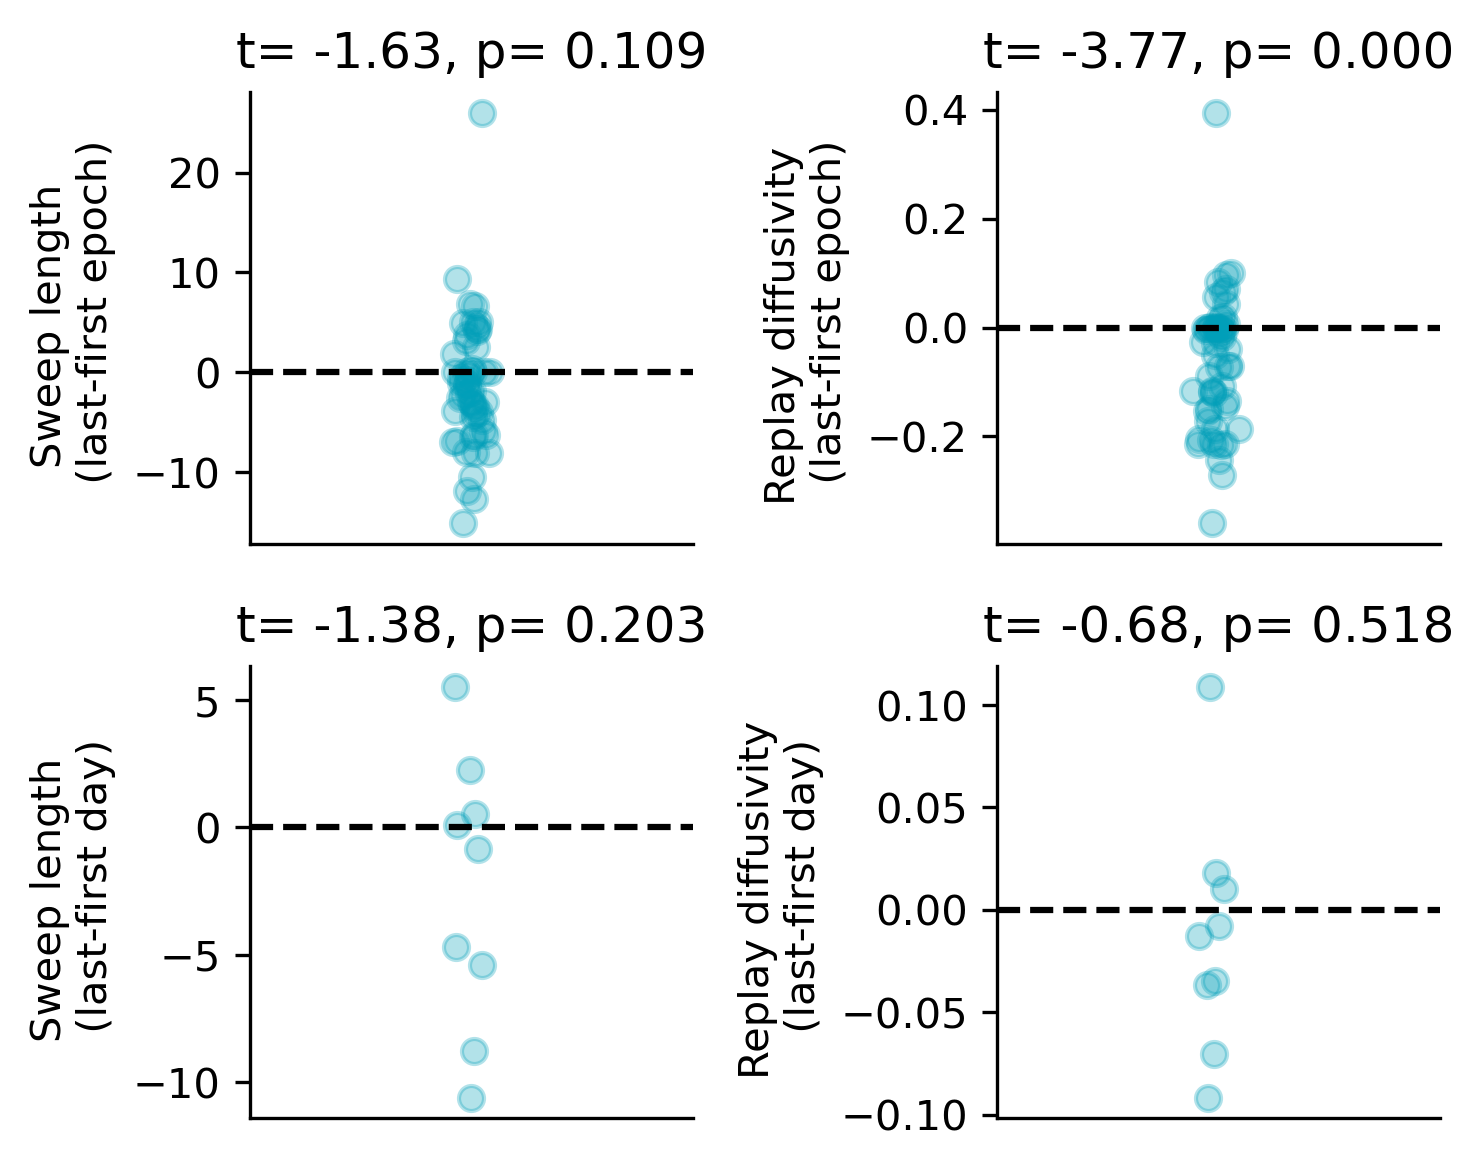

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), dpi=300)

ax0 = axs[0,0]
Diff = []
for key, value in all_sweep_amp_perday.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax0.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
ax0.set_xlim([0.5, 1.5])
#add a horizontal line at y=0
ax0.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
from scipy.stats import ttest_1samp
t, p = ttest_1samp(Diff, 0)
#add t and p value to the plot as text
ax0.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax0.set_xticks([])
ax0.set_ylabel('Sweep length \n (last-first epoch)')
#right and top spines are not visible
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)



ax1 = axs[0,1]
Diff = []
for key, value in all_exponent_perday.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax1.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
#xlim([0.5, 1.5]
ax1.set_xlim([0.5, 1.5])
#add y=0 horizontal line
ax1.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
t, p = ttest_1samp(Diff, 0)
ax1.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax1.set_xticks([])
ax1.set_ylabel('Replay diffusivity \n (last-first epoch)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = axs[1,0]
Diff = []
for key, value in all_sweep_amp_perday_concat.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax2.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
#xlim([0.5, 1.5]
ax2.set_xlim([0.5, 1.5])
#add y=0 horizontal line
ax2.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
t, p = ttest_1samp(Diff, 0)
ax2.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax2.set_xticks([])
ax2.set_ylabel('Sweep length \n (last-first day)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3 = axs[1,1]
Diff = []
for key, value in all_exponent_perday_concat.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax3.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
#xlim([0.5, 1.5]
ax3.set_xlim([0.5, 1.5])
#add y=0 horizontal line
ax3.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
t, p = ttest_1samp(Diff, 0)
ax3.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax3.set_xticks([])
ax3.set_ylabel('Replay diffusivity \n (last-first day)')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.tight_layout()